In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('BabayanEtAl_VirusData.csv')
print(df.describe())

C:\Users\pzgoh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


              CpG         UpA         ApA         ApC         ApG         ApU  \
count  536.000000  536.000000  536.000000  536.000000  536.000000  536.000000   
mean     0.491574    0.686039    1.018281    0.984138    1.026542    0.972453   
std      0.186845    0.133710    0.084484    0.106347    0.095469    0.083642   
min      0.135886    0.354180    0.824692    0.743935    0.715767    0.688956   
25%      0.363609    0.583950    0.958620    0.900280    0.974191    0.918564   
50%      0.476754    0.683799    1.008764    0.971006    1.028597    0.968300   
75%      0.594700    0.789139    1.060061    1.052237    1.085965    1.034035   
max      1.073316    1.082434    1.555675    1.320062    1.283968    1.214170   

              CpA         CpC         CpU         GpA  ...    TCG.Bias  \
count  536.000000  536.000000  536.000000  536.000000  ...  536.000000   
mean     1.247771    1.073916    1.117695    1.098532  ...    0.065925   
std      0.096561    0.105792    0.098985    0.1

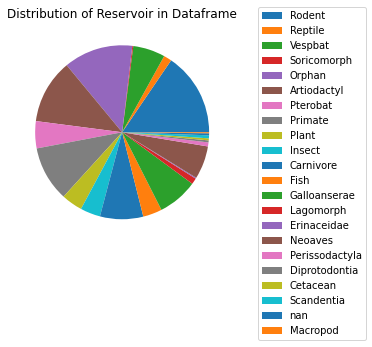

In [2]:
reservoir_types = {}
for host in df['Reservoir']:
    if host in reservoir_types.keys():
        reservoir_types[host] += 1
    else:
        reservoir_types[host] = 1
#print(reservoir_types)
labels = list(reservoir_types.keys())
counts = list(reservoir_types.values())
plt.pie(counts,labels=labels, labeldistance=None)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
plt.title('Distribution of Reservoir in Dataframe')
plt.show()

In [3]:
todrop = []
for key,value in reservoir_types.items():
    if value <15:
        todrop.append(key)
todrop.append('Orphan')
df = df[df['Reservoir'].notna()] #remove nan from reservoir
df.drop(columns = ['Virus name', 'Genbank accession', 'Viral group', 'Vector-borne', 'Vector'], inplace = True)
diff_reservoir = []
print(todrop)
todroplist = []
for index, host in enumerate(df["Reservoir"]):
    if host in todrop:
        todroplist.append(index)

['Reptile', 'Soricomorph', 'Lagomorph', 'Erinaceidae', 'Perissodactyla', 'Diprotodontia', 'Cetacean', 'Scandentia', nan, 'Macropod', 'Orphan']


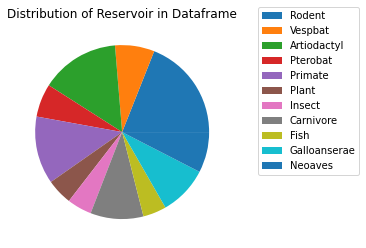

In [4]:
new_df = df[~df['Reservoir'].isin(todrop)]       
new_reservoir_types = {}
for host in new_df['Reservoir']:
    if host in new_reservoir_types.keys():
        new_reservoir_types[host] += 1
    else:
        new_reservoir_types[host] = 1
#print(reservoir_types)
labels = list(new_reservoir_types.keys())
counts = list(new_reservoir_types.values())
plt.pie(counts,labels=labels, labeldistance=None)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
plt.title('Distribution of Reservoir in Dataframe')
plt.show()

new_df.to_csv('NewReducedBabayanEtAl_VirusData.csv', index = True)

In [5]:
for host in new_df['Reservoir']:
    if host not in diff_reservoir:
        diff_reservoir.append(host)
for host in diff_reservoir:
    new_df['Reservoir'].replace({host:diff_reservoir.index(host)+2},inplace = True)
new_df.to_csv('FINALNewReducedBabayanEtAl_VirusData.csv', index = False)

C:\Users\pzgoh\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Data Cleaning + Splitting

Size of train-test split : 349 88


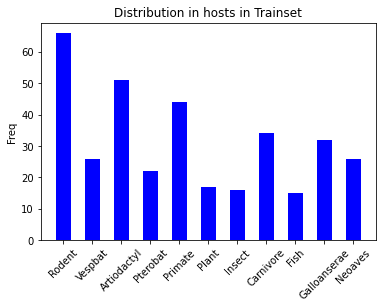

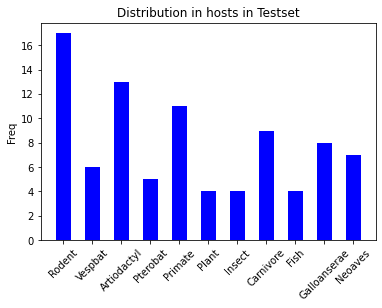

In [6]:
#Split train test data
X = new_df.drop("Reservoir", axis=1)
Y = new_df['Reservoir']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42, stratify=Y)
testtrain = [y_train, y_test]

print("Size of train-test split :",len(y_train),len(y_test))
count= 0
host_dict = {}
for set1 in testtrain:
    for host in diff_reservoir:
        host_dict[host] = 0
    for host_no in set1:
        host_dict[diff_reservoir[int(host_no)-2]] += 1
    plt.bar(diff_reservoir,host_dict.values(), color ='blue',width = 0.5)
    plt.xticks(rotation=45)
    plt.ylabel("Freq")
    if count == 0:
        plt.title("Distribution in hosts in Trainset")
    else:
        plt.title("Distribution in hosts in Testset")
    count = 1
    plt.show()


ANN Setup

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
from torch.nn import functional as F

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train) #it transforms and then fit, so its additive
X_test = sc.transform(X_test) #so that the model does not learn this set of test data
print(X_train.shape)
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
training_list, training_list2, testing_list = [],[],[]
for ele in y_train:
    ans = []
    for i in range(11):
        ans.append(float(0))   
    ans[ele-2] = float(1)
    training_list.append(ans)
    training_list2.append(ele-2)
    
y_for_loss =  torch.tensor(training_list)
y_train_val = torch.tensor(training_list2)

for ele in y_test:
    testing_list.append(ele-2)
y_test_val = torch.tensor(testing_list)
# print("y_train for loss cal :", y_for_loss, "\n")
# print("y_train for accuracy cal :", y_train_val, "\n")
# print("y_test for accuracy cal :", y_test_val, "\n")


(349, 4229)


In [16]:
class DiseaseNN(nn.Module):
    def __init__(self):
        super(DiseaseNN, self).__init__()
        self.fc1 = nn.Linear(4229, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,11)
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        #self.sm = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.dropout(self.activate(self.fc1(x)))
        x = self.dropout(self.activate(self.fc2(x)))
        x = self.dropout(self.activate(self.fc3(x)))# every layer drop
        return self.fc4(x)
meanacc = []
for i in range(10):
    net = DiseaseNN()
    optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    losses,accuracy_list1,accuracy_list2 = [],[],[]
    max_test,patience = 0,0
    best_params = net.state_dict()
    best_epoch = -1
    for epoch in range(1, 100):
        optimizer.zero_grad() #reset gradients after each epoch
        net.train()
        outputs = net(X_train)
        #print("line 27 outputs will be",outputs)
        #print(y_for_loss)
        loss = criterion(outputs, y_for_loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.item()) #so as to reduce mem
        preds_y  = torch.argmax(outputs,1)
    #     print(y_train_val)
    #     print(preds_y)
        train_acc = accuracy_score(y_train_val, preds_y)

        net.eval()
        pred_test = net(X_test)
        preds_test_y = torch.argmax(pred_test, 1)
    #     print("correct y is ", y_test_val)
    #     print("predicted y to be",preds_test_y)
        test_acc = accuracy_score(y_test_val, preds_test_y)
#         print("Epoch {}, Loss: {}, Train Acc:{:.2f}%, Test Acc: {:.2f}%".format(epoch, loss.item(), 
#                                                                         train_acc*100, test_acc * 100))
        accuracy_list2.append(test_acc*100)
        accuracy_list1.append(train_acc*100)
        if test_acc > max_test:
            patience = 0
            max_test = test_acc
            best_params = net.state_dict()
            best_epoch = epoch
        elif test_acc <= max_test:
            patience += 1
        if patience >= 20: 
            break
    #print(best_epoch)
    print(accuracy_list2[best_epoch-1])
    meanacc.append(accuracy_list2[best_epoch-1])
print(sum(meanacc)/len(meanacc))

63.63636363636363
64.77272727272727
65.9090909090909
64.77272727272727
64.77272727272727
61.36363636363637
64.77272727272727
63.63636363636363
64.77272727272727
61.36363636363637
63.97727272727273


In [17]:
correct_d, wrong_d = [],[]
for i in range(11):
    correct_d.append(0)
    wrong_d.append(0)
for idx, item in enumerate(y_test):
    if (item-2) == preds_test_y[idx]:
        correct_d[item-2] += 1
    else:
        wrong_d[item-2] += 1
print(correct_d)
print("---------")
print(wrong_d)
for i in range(11):
    accuracy_score11 = correct_d[i]/(correct_d[i]+wrong_d[i])
    print(diff_reservoir[i], accuracy_score11)

[11, 0, 7, 2, 10, 4, 2, 3, 2, 5, 4]
---------
[6, 6, 6, 3, 1, 0, 2, 6, 2, 3, 3]
Rodent 0.6470588235294118
Vespbat 0.0
Artiodactyl 0.5384615384615384
Pterobat 0.4
Primate 0.9090909090909091
Plant 1.0
Insect 0.5
Carnivore 0.3333333333333333
Fish 0.5
Galloanserae 0.625
Neoaves 0.5714285714285714


[0.6363636363636364, 0.6477272727272727, 0.6590909090909091, 0.6477272727272727, 0.6477272727272727, 0.6136363636363636, 0.6477272727272727, 0.6363636363636364, 0.6477272727272727, 0.6136363636363636]
0.6397727272727273
0.6363636363636364 0.6477272727272727


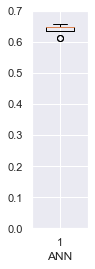

In [34]:
import matplotlib.pyplot as plt
meanacc1 = []
for value in meanacc:
    v1 = value/100
    meanacc1.append(v1)
print(meanacc1)
print(sum(meanacc1)/10)
q1,q3 = np.percentile(meanacc1, [25,75])
print(q1,q3)
plt.figure().set_figwidth(1)
plt.boxplot(meanacc1, meanline = True, widths = 0.5)
plt.ylim(0,0.7)
plt.xlabel('ANN')
plt.show()

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# print("correct y is ", y_test_val)
# print("predicted y to be",preds_test_y)

ans,finalans = [],[]
for i in range(11):
    ans.append([0,0,0,0,0,0,0,0,0,0,0])
for index,correct in enumerate(y_test_val):
    ans[correct][preds_test_y[index]] += 1
# print(ans)
# print(diff_reservoir)
totaltestsize = list(host_dict.values())
print(totaltestsize)

for index,row in enumerate(ans):
    finallist= []
    for item in row:
        try:
            finalitem = round(item/totaltestsize[index],2)
        except ZeroDivisionError:
            finalitem = 0
        finallist.append(finalitem)
    finalans.append(finallist)
print(finalans)

[17, 6, 13, 5, 11, 4, 4, 9, 4, 8, 7]
[[0.65, 0.0, 0.18, 0.06, 0.06, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.67, 0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17], [0.08, 0.0, 0.54, 0.08, 0.08, 0.08, 0.0, 0.08, 0.0, 0.08, 0.0], [0.0, 0.0, 0.0, 0.4, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0], [0.0, 0.0, 0.0, 0.0, 0.91, 0.0, 0.0, 0.0, 0.0, 0.09, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.5, 0.0, 0.25, 0.0, 0.0], [0.33, 0.0, 0.22, 0.0, 0.11, 0.0, 0.0, 0.33, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0], [0.0, 0.0, 0.12, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.62, 0.0], [0.14, 0.0, 0.0, 0.0, 0.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.57]]


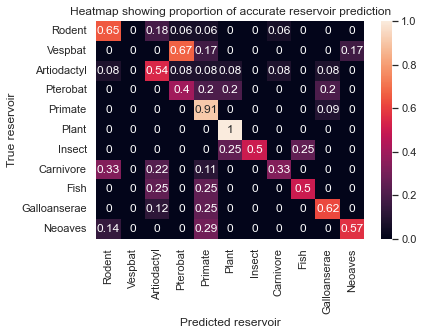

In [23]:
np.random.seed(0)
sns.set()
df11 = pd.DataFrame(finalans)
ax = sns.heatmap(df11, vmin=0, vmax=1,annot = True ,yticklabels=diff_reservoir, xticklabels=diff_reservoir)
plt.title("Heatmap showing proportion of accurate reservoir prediction")
plt.xlabel('Predicted reservoir')
plt.ylabel('True reservoir')
plt.show()